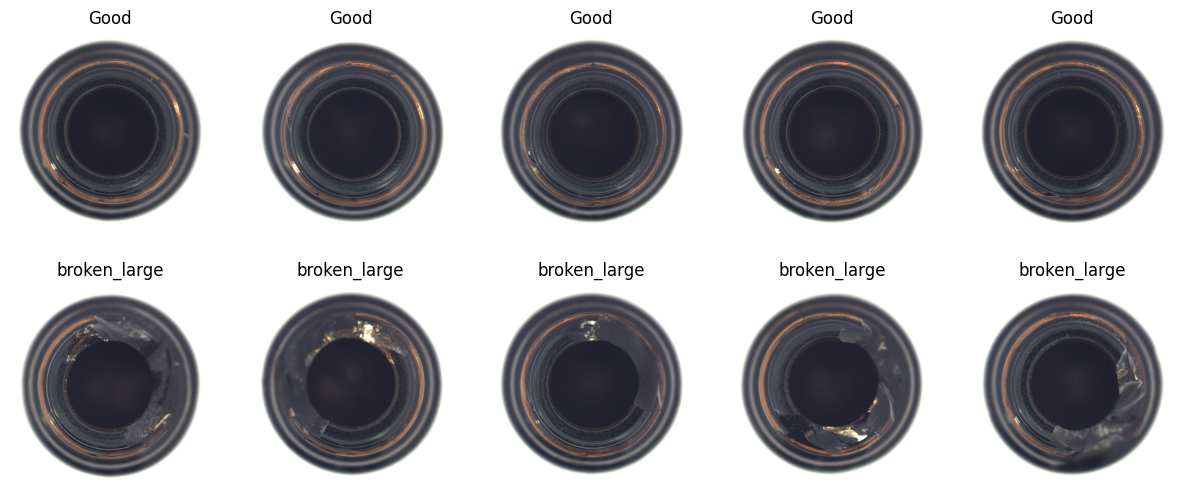

In [6]:
import os
import matplotlib.pyplot as plt
import random

def display_good_and_anomalous_images(base_path, anomaly_type, num_images=5):
    """
    Displays a mix of 'good' and 'anomalous' images from the specified MVTec category.
    
    Parameters:
    - base_path (str): Base path to the MVTec dataset.
    - category (str): The category (e.g., "bottle", "capsule") to display images from.
    - anomaly_type (str): The specific type of anomaly (e.g., "broken_large", "contamination").
    - num_images (int): Number of images to display for each type (good and anomalous).
    """
    # Paths to good and anomalous images
    good_path = os.path.join(base_path, "train", "good")
    anomaly_path = os.path.join(base_path, "test", anomaly_type)

    # List all images in the directories
    good_images = os.listdir(good_path)
    anomaly_images = os.listdir(anomaly_path)

    # Randomly select images to display
    selected_good_images = random.sample(good_images, min(num_images, len(good_images)))
    selected_anomaly_images = random.sample(anomaly_images, min(num_images, len(anomaly_images)))

    # Plot the images
    fig, axes = plt.subplots(2, num_images, figsize=(15, 6))
    
    # Display good images
    for i, img_name in enumerate(selected_good_images):
        img_path = os.path.join(good_path, img_name)
        img = plt.imread(img_path)
        axes[0, i].imshow(img)
        axes[0, i].axis("off")
        axes[0, i].set_title("Good")

    # Display anomalous images
    for i, img_name in enumerate(selected_anomaly_images):
        img_path = os.path.join(anomaly_path, img_name)
        img = plt.imread(img_path)
        axes[1, i].imshow(img)
        axes[1, i].axis("off")
        axes[1, i].set_title(anomaly_type)

    plt.show()

# Example usage
# Set the base path to the MVTec dataset location on your computer
base_path = "bottle/bottle" # cooked path
display_good_and_anomalous_images(base_path,  anomaly_type="broken_large", num_images=5)


In [18]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import roc_auc_score




In [12]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim=64*64*3, hidden_dim=512):
        super(AutoEncoder, self).__init__()
        # Encoder 
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, input_dim),
            nn.Sigmoid(),
            nn.Unflatten(1,(3, 64, 64))
        )

    def forward(self, x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return decode




In [34]:
class MVTecDataset(Dataset):
    def __init__(self, root_dir, transform, is_train):
        """
        Args:
            root_dir (str): Root directory of MVTec AD dataset
            category (str): Category name (e.g., 'bottle', 'cable', etc.)
            is_train (bool): If True, load training data, else test data
            transform: transform to be applied on images
        """
        self.root_dir = root_dir
        self.is_train = is_train
        self.transform = transform
        
        # Set up paths
        if is_train:
            self.image_paths = self._get_image_paths('train/good')
        else:
            self.image_paths = self._get_image_paths('test/good')
            self.image_paths.extend(self._get_defect_image_paths('test'))
            
    def _get_image_paths(self, subset):
        path = os.path.join(self.root_dir, subset)
        if not os.path.exists(path):
            return []
        return [os.path.join(path, f) for f in os.listdir(path) if f.endswith(('.png', '.jpg'))]
    
    def _get_defect_image_paths(self, subset):
        paths = []
        defect_types = ["broken_large", "broken_small", "contamination"]
        
        for defect in defect_types:
            defect_path = os.path.join(self.root_dir, subset, defect)
            paths.extend([os.path.join(defect_path, f) for f in os.listdir(defect_path)])
        return paths
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)
        
        # 1 for good; 0 for defect
        label = 1 if 'good' in img_path else 0
        return image, label


In [35]:
# Path to 'good' training images for bottle category
path = "bottle/bottle/"


transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

train_dataset = MVTecDataset(path, transform, is_train=True)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = MVTecDataset(path, transform, is_train=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)



Epoch 1/10: 100%|██████████| 14/14 [00:03<00:00,  4.08it/s]


Epoch [1/10], Average Loss: 0.024297


Epoch 2/10: 100%|██████████| 14/14 [00:03<00:00,  4.11it/s]


Epoch [2/10], Average Loss: 0.001830


Epoch 3/10: 100%|██████████| 14/14 [00:03<00:00,  4.12it/s]


Epoch [3/10], Average Loss: 0.001170


Epoch 4/10: 100%|██████████| 14/14 [00:03<00:00,  4.06it/s]


Epoch [4/10], Average Loss: 0.001265


Epoch 5/10: 100%|██████████| 14/14 [00:03<00:00,  3.96it/s]


Epoch [5/10], Average Loss: 0.001103


Epoch 6/10: 100%|██████████| 14/14 [00:03<00:00,  4.06it/s]


Epoch [6/10], Average Loss: 0.001131


Epoch 7/10: 100%|██████████| 14/14 [00:03<00:00,  4.06it/s]


Epoch [7/10], Average Loss: 0.001114


Epoch 8/10: 100%|██████████| 14/14 [00:03<00:00,  4.06it/s]


Epoch [8/10], Average Loss: 0.001099


Epoch 9/10: 100%|██████████| 14/14 [00:03<00:00,  4.05it/s]


Epoch [9/10], Average Loss: 0.001151


Epoch 10/10: 100%|██████████| 14/14 [00:03<00:00,  4.10it/s]

Epoch [10/10], Average Loss: 0.001127


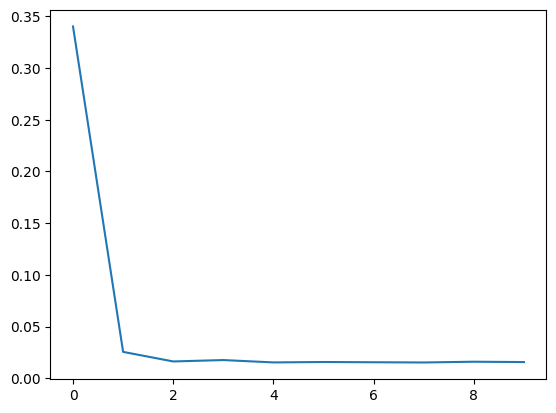

In [21]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LR = 0.001
ae = AutoEncoder().to(device)
optimizer = optim.Adam(ae.parameters(), lr=LR)

def train_autoencoder(model, train_loader, num_epochs, learning_rate=LR, device='cpu'):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    losses = []
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        #tqdm gives nice terminal display
        for batch_data, _ in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            data = batch_data.to(device)
            reconstructed = model(data)
            
            loss = criterion(reconstructed, data)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
        losses.append(total_loss)
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.6f}')
    return losses

losses = train_autoencoder(ae, train_loader, num_epochs=10, learning_rate=LR, device=device)
plt.plot(losses)


In [60]:
def get_anomaly_value(model, test_loader, device='cuda'):
    model.eval()
    
    good_errors = []
    anomaly_errors = []
    good_count = 0
    anomaly_count = 0
    
    with torch.no_grad():
        for batch_data, batch_labels in test_loader:
            data = batch_data.to(device)
            labels = batch_labels.to(device)
            
            reconstructed = model(data)
            
            # not rly sure this is the correct way to do it
            errors = torch.mean((data - reconstructed) ** 2, dim=(1,2,3))
            
            good_mask = labels == 1
            anomaly_mask = labels == 0
            
            good_errors.extend(errors[good_mask].cpu().numpy())
            anomaly_errors.extend(errors[anomaly_mask].cpu().numpy())
            
            good_count += good_mask.sum().item()
            anomaly_count += anomaly_mask.sum().item()
    
    good_errors = np.array(good_errors)
    anomaly_errors = np.array(anomaly_errors)
    seperator = (good_errors.sum() + anomaly_errors.sum()) / (good_count + anomaly_count)
    return seperator

anomaly_threshold = get_anomaly_value(ae, test_loader)
print(anomaly_threshold)


0.0023333627775491


In [66]:
def get_predictions(model, loader, threshold, device='cuda'):

    model.eval()
    predictions = []
    true_labels = []
    reconstruction_errors = []
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            reconstructed = model(images)
            
            # Calculate reconstruction error (MSE) for each image
            error = torch.mean((images - reconstructed) ** 2, dim=(1, 2, 3))
            reconstruction_errors.extend(error.cpu().numpy())
            
            # Classify as anomaly if reconstruction error > threshold
            pred = (error > threshold).float()
            predictions.extend(pred.cpu().numpy())
            
            # Convert labels to binary (1: good, 0: anomaly)
            true_labels.extend(labels.float().cpu().numpy())
    
    # Convert lists to numpy arrays
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    reconstruction_errors = np.array(reconstruction_errors)
    return predictions, true_labels, reconstruction_errors

p, t, r = get_predictions(ae, test_loader, anomaly_threshold, device)

print(f"accuracy = {np.mean(p == t)}")



accuracy = 0.3855421686746988


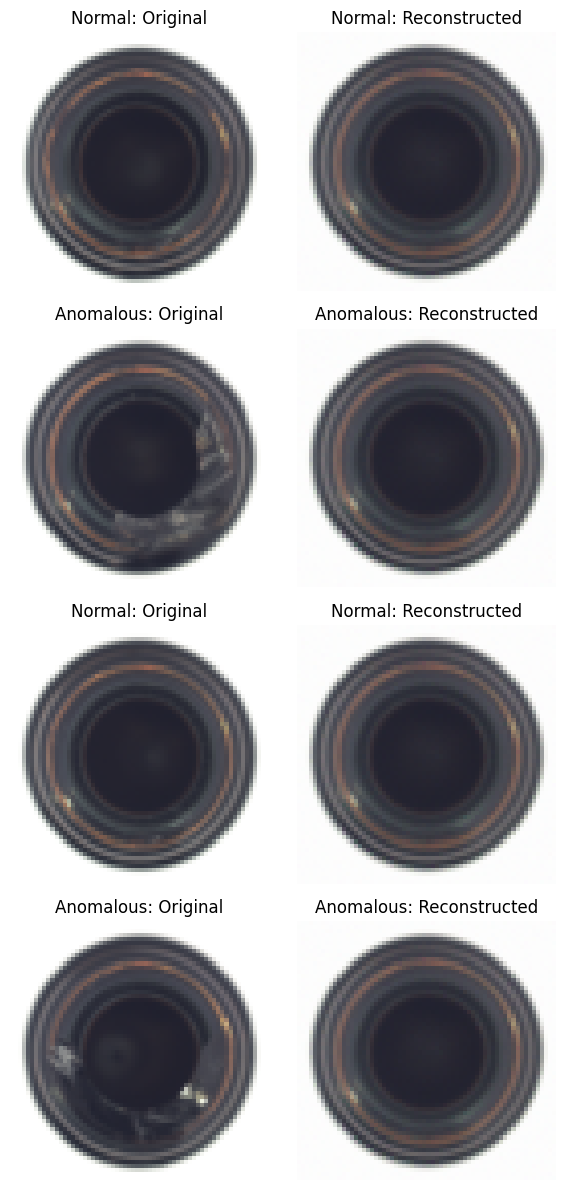

In [72]:
def plot_original_and_reconstructed_with_anomalies(model, data_loader, device, num_images=2):
    """
    Plot original and reconstructed images side by side, including anomalous images.
    
    Args:
        model: Trained autoencoder model.
        data_loader: DataLoader providing the images and labels.
        device: Device where the model is located ('cuda' or 'cpu').
        num_images: Number of images to display for both normal and anomalous images.
    """
    model.eval()  # Set the model to evaluation mode

    normal_images = []
    normal_reconstructions = []
    anomalous_images = []
    anomalous_reconstructions = []

    # Get a single batch of images and filter normal and anomalous samples
    with torch.no_grad():
        for batch_data, labels in data_loader:
            batch_data = batch_data.to(device)
            reconstructed = model(batch_data)
            batch_data = batch_data.cpu().numpy()
            reconstructed = reconstructed.cpu().numpy()
            labels = labels.cpu().numpy()
            
            # Separate normal and anomalous images
            for i in range(len(labels)):
                if labels[i] == 1 and len(normal_images) < num_images:
                    normal_images.append(batch_data[i])
                    normal_reconstructions.append(reconstructed[i])
                elif labels[i] == 0 and len(anomalous_images) < num_images:
                    anomalous_images.append(batch_data[i])
                    anomalous_reconstructions.append(reconstructed[i])
            
            # Break if we have enough samples for both categories
            if len(normal_images) >= num_images and len(anomalous_images) >= num_images:
                break
    
    # Plot the images
    fig, axes = plt.subplots(num_images * 2, 2, figsize=(6, num_images * 6))
    for i in range(num_images):
        # Normal images
        axes[2 * i, 0].imshow(normal_images[i].transpose(1, 2, 0))  # CHW to HWC
        axes[2 * i, 0].set_title("Normal: Original")
        axes[2 * i, 0].axis('off')

        axes[2 * i, 1].imshow(normal_reconstructions[i].transpose(1, 2, 0))  # CHW to HWC
        axes[2 * i, 1].set_title("Normal: Reconstructed")
        axes[2 * i, 1].axis('off')
        
        # Anomalous images
        axes[2 * i + 1, 0].imshow(anomalous_images[i].transpose(1, 2, 0))  # CHW to HWC
        axes[2 * i + 1, 0].set_title("Anomalous: Original")
        axes[2 * i + 1, 0].axis('off')

        axes[2 * i + 1, 1].imshow(anomalous_reconstructions[i].transpose(1, 2, 0))  # CHW to HWC
        axes[2 * i + 1, 1].set_title("Anomalous: Reconstructed")
        axes[2 * i + 1, 1].axis('off')

    plt.tight_layout()
    plt.show()


        
plot_original_and_reconstructed_with_anomalies(ae, test_loader, device)